In [5]:
import zipfile
import os

zip_filename = "/content/68e8d1d70b66d_student_resource.zip"

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    extract_path = "/content/extracted_files"
    zip_ref.extractall(extract_path)

print(f"Extracted to: {extract_path}")

for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")


Extracted to: /content/extracted_files
extracted_files/
  __MACOSX/
    ._student_resource
    student_resource/
      ._sample_code.py
      ._src
      ._.DS_Store
      ._dataset
      ._README.md
      ._Documentation_template.md
      dataset/
        ._train.csv
        ._sample_test.csv
        ._sample_test_out.csv
        ._test.csv
      src/
        ._utils.py
        ._example.ipynb
        .___pycache__
        __pycache__/
          ._utils.cpython-37.pyc
  student_resource/
    .DS_Store
    Documentation_template.md
    sample_code.py
    README.md
    dataset/
      sample_test.csv
      train.csv
      sample_test_out.csv
      test.csv
    src/
      utils.py
      example.ipynb
      __pycache__/
        utils.cpython-37.pyc


In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

base_path = "/content/extracted_files/student_resource/dataset"

train_path = f"{base_path}/train.csv"
test_path  = f"{base_path}/test.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

train_df.head()


Train shape: (75000, 4)
Test shape : (75000, 3)


,sample_id,catalog_content,image_link,price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sample_id        75000 non-null  int64  
 1   catalog_content  75000 non-null  object 
 2   image_link       75000 non-null  object 
 3   price            75000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.3+ MB
sample_id          0
catalog_content    0
image_link         0
price              0
dtype: int64
count    75000.000000
mean        23.647654
std         33.376932
min          0.130000
25%          6.795000
50%         14.000000
75%         28.625000
max       2796.000000
Name: price, dtype: float64
Duplicate IDs in train: 0


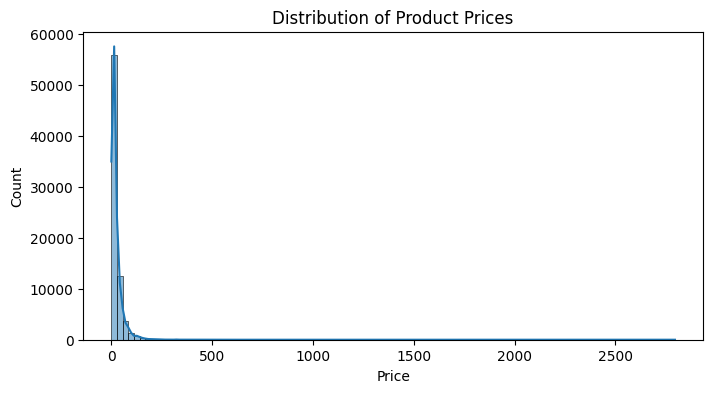

In [7]:

train_df.info()
print(train_df.isna().sum())

print(train_df["price"].describe())

print("Duplicate IDs in train:", train_df["sample_id"].duplicated().sum())

plt.figure(figsize=(8,4))
sns.histplot(train_df["price"], bins=100, kde=True)
plt.title("Distribution of Product Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()


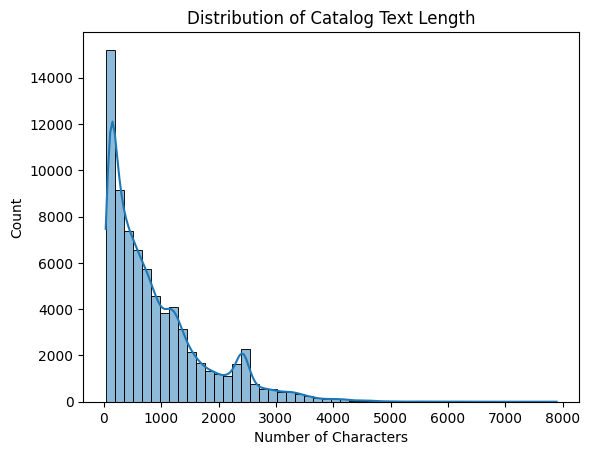


--- Example 1 ---
Item Name: La Victoria Green Taco Sauce Mild, 12 Ounce (Pack of 6)
Value: 72.0
Unit: Fl Oz

Price: 4.890000000000001

--- Example 2 ---
Item Name: Salerno Cookies, The Original Butter Cookies, 8 Ounce (Pack of 4)
Bullet Point 1: Original Butter Cookies: Classic butter cookies made with real butter
Bullet Point 2: Variety Pack: Includes 4 boxes with 32 cookies total
Bullet Point 3: Occasion Perfect: Delicious cookies for birthdays, w
Price: 13.12

--- Example 3 ---
Item Name: Bear Creek Hearty Soup Bowl, Creamy Chicken with Rice, 1.9 Ounce (Pack of 6)
Bullet Point 1: Loaded with hearty long grain wild rice and vegetables
Bullet Point 2: Full of hearty goodness
Bullet Point 3: Single serve bowls
Bullet Point 4: Easy to prepare mix
Bullet Point 5: 0 grams trans 
Price: 1.97


In [8]:

train_df["text_length"] = train_df["catalog_content"].astype(str).apply(len)

sns.histplot(train_df["text_length"], bins=50, kde=True)
plt.title("Distribution of Catalog Text Length")
plt.xlabel("Number of Characters")
plt.show()

for i in range(3):
    print(f"\n--- Example {i+1} ---")
    print(train_df.loc[i, "catalog_content"][:300])  # show first 300 chars
    print(f"Price: {train_df.loc[i, 'price']}")


NEW

GJGHG


In [28]:
!pip install sentence-transformers timm


In [3]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import timm


In [4]:
base_path = "/content/extracted_files/student_resource/dataset"

train_df = pd.read_csv(f"{base_path}/train.csv")
test_df  = pd.read_csv(f"{base_path}/test.csv")

# Extract IPQ
import re
def extract_ipq(text):
    text = str(text).lower()
    m = re.search(r'(?:pack of|pack|pcs|pc|pieces|x)\s*([0-9]{1,4})', text)
    if m: return float(m.group(1))
    m2 = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*(ml|l|g|kg|oz|count|ct|tablet|capsule|piece|pcs|pc)', text)
    if m2: return float(m2.group(1))
    m3 = re.search(r'([0-9]{1,4})', text)
    if m3: return float(m3.group(1))
    return 1.0

for df in [train_df, test_df]:
    df['ipq'] = df['catalog_content'].apply(extract_ipq)
    df['text_length'] = df['catalog_content'].astype(str).apply(len)
    df['word_count'] = df['catalog_content'].astype(str).apply(lambda x: len(x.split()))

numeric_cols = ["ipq", "text_length", "word_count"]
X_numeric_train = train_df[numeric_cols].values
X_numeric_test  = test_df[numeric_cols].values

# Log-transform target
y_train = np.log1p(train_df['price'].values)


In [5]:
text_model = SentenceTransformer('all-mpnet-base-v2', device='cuda' if torch.cuda.is_available() else 'cpu')

X_text_train = text_model.encode(train_df['catalog_content'].tolist(), batch_size=32, show_progress_bar=True)
X_text_test  = text_model.encode(test_df['catalog_content'].tolist(), batch_size=32, show_progress_bar=True)

print("Text embeddings:", X_text_train.shape)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/2344 [00:00<?, ?it/s]

Batches:   0%|          | 0/2344 [00:00<?, ?it/s]

Text embeddings: (75000, 768)


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
image_dir = "/content/extracted_files/images"

resnet_model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0).to(device)
resnet_model.eval()

transform = timm.data.transforms_factory.create_transform(
    input_size=300, is_training=False
)

def encode_images(df, image_dir):
    embeddings = []
    for img_id in tqdm(df['sample_id'].tolist()):
        path = os.path.join(image_dir, f"{img_id}.jpg")
        if os.path.exists(path):
            img = Image.open(path).convert('RGB')
            img = transform(img).unsqueeze(0).to(device)
            with torch.no_grad():
                emb = resnet_model(img).cpu().numpy()
            embeddings.append(emb.flatten())
        else:
            embeddings.append(np.zeros(resnet_model.num_features))
    return np.vstack(embeddings)

X_img_train = encode_images(train_df, image_dir)
X_img_test  = encode_images(test_df, image_dir)


100%|██████████| 75000/75000 [00:01<00:00, 51580.86it/s]


In [7]:
X_train_full = np.hstack([X_numeric_train, X_text_train, X_img_train])
X_test_full  = np.hstack([X_numeric_test, X_text_test, X_img_test])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_test_full  = scaler.transform(X_test_full)


In [8]:
class PriceDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32) if y is not None else None
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]

train_dataset = PriceDataset(X_train_full, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


In [9]:
class PriceModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    def forward(self, x):
        return self.model(x).squeeze(-1)

model = PriceModel(X_train_full.shape[1]).to(device)


In [10]:
def smape_loss(y_pred, y_true):
    epsilon = 1e-6
    numerator = torch.abs(y_pred - y_true)
    denominator = (torch.abs(y_pred) + torch.abs(y_true) + epsilon)/2
    return torch.mean(numerator / denominator) * 100


In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
epochs = 200

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = smape_loss(torch.expm1(preds), torch.expm1(y_batch))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, SMAPE Loss: {epoch_loss/len(train_loader):.4f}")


Epoch 1/200, SMAPE Loss: 18.9546
Epoch 2/200, SMAPE Loss: 18.8435
Epoch 3/200, SMAPE Loss: 18.9125
Epoch 4/200, SMAPE Loss: 18.8680
Epoch 5/200, SMAPE Loss: 18.6738
Epoch 6/200, SMAPE Loss: 18.7917
Epoch 7/200, SMAPE Loss: 18.9172
Epoch 8/200, SMAPE Loss: 18.8369
Epoch 9/200, SMAPE Loss: 18.7790
Epoch 10/200, SMAPE Loss: 18.6332
Epoch 11/200, SMAPE Loss: 18.7511
Epoch 12/200, SMAPE Loss: 18.6950
Epoch 13/200, SMAPE Loss: 18.6324
Epoch 14/200, SMAPE Loss: 18.7130
Epoch 15/200, SMAPE Loss: 18.6740
Epoch 16/200, SMAPE Loss: 18.6109
Epoch 17/200, SMAPE Loss: 18.6024
Epoch 18/200, SMAPE Loss: 18.5138
Epoch 19/200, SMAPE Loss: 18.5766
Epoch 20/200, SMAPE Loss: 18.3137
Epoch 21/200, SMAPE Loss: 18.5758
Epoch 22/200, SMAPE Loss: 18.6801
Epoch 23/200, SMAPE Loss: 18.5696
Epoch 24/200, SMAPE Loss: 18.5466
Epoch 25/200, SMAPE Loss: 18.4502
Epoch 26/200, SMAPE Loss: 18.3605
Epoch 27/200, SMAPE Loss: 18.2980
Epoch 28/200, SMAPE Loss: 18.5937
Epoch 29/200, SMAPE Loss: 18.5550
Epoch 30/200, SMAPE Los

In [ ]:
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_full, dtype=torch.float32).to(device)
    preds_log = model(X_test_tensor).cpu().numpy()
    preds = np.expm1(preds_log)
    preds = np.clip(preds, 0, None)

submission = pd.DataFrame({
    "sample_id": test_df["sample_id"],
    "price": preds
})
submission.to_csv("test_out.csv", index=False)
